<a href="https://colab.research.google.com/github/seunghee0518/AI_python/blob/main/googlenet_with_MVtec_AD_Dataset%5Bimplemented_in_Keras%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

googlenet with keras
[비전 시스템을 위한 딥러닝 by moelgendy]

https://github.com/moelgendy/deep_learning_for_vision_systems/blob/master/chapter_05/inception_implementation_in_keras.ipynb

# 데이터 셋 전처리 및 시각화

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import os # miscellaneous operating system interfaces
import shutil # high-level file operations
from glob import glob
from tqdm import tqdm

In [3]:
base_dir = '/content/drive/MyDrive/DACON_이상치 탐지 알고리즘 경진대회/open/'
train_dir = '/content/drive/MyDrive/DACON_이상치 탐지 알고리즘 경진대회/open/train'
test_dir = '/content/drive/MyDrive/DACON_이상치 탐지 알고리즘 경진대회/open/test'

train_df = pd.read_csv('/content/drive/MyDrive/DACON_이상치 탐지 알고리즘 경진대회/open/train_df.csv')
test_df = pd.read_csv('/content/drive/MyDrive/DACON_이상치 탐지 알고리즘 경진대회/open/test_df.csv')

In [4]:
len(os.listdir(train_dir)), len(os.listdir(test_dir))

(4277, 2154)

In [11]:
## train 데이터 개수 및 레이블 개수
train_label = train_df.label.tolist()
train_label_unique = list(set(train_label))
print(len(train_label), len(train_label_unique))

4277 88


In [ ]:
# ## 88개 레이블 폴더 생성
# os.mkdir(base_dir+f'train_label_88')
# for dir in train_label_unique:
#   os.mkdir(base_dir+f'train_label_88/{dir}')

In [12]:
train_df

,index,file_name,class,state,label
0,0,10000.png,transistor,good,transistor-good
1,1,10001.png,capsule,good,capsule-good
2,2,10002.png,transistor,good,transistor-good
3,3,10003.png,wood,good,wood-good
4,4,10004.png,bottle,good,bottle-good
...,...,...,...,...,...
4272,4272,14272.png,transistor,good,transistor-good
4273,4273,14273.png,transistor,good,transistor-good
4274,4274,14274.png,grid,good,grid-good
4275,4275,14275.png,zipper,good,zipper-good


In [ ]:
# import shutil
# from tqdm import tqdm

# for i in tqdm(range(len(train_df))):
#   file_name = train_df.loc[i, 'file_name']
#   label     = train_df.loc[i, 'label']

#   source = train_dir + f'/{file_name}'
#   destination = base_dir + f'train_label_88/{label}/{file_name}'
#   shutil.copyfile(source, destination) # 이동이 아닌 카피로 실행함
#   # shutil.move(file_source, file_destination) # 이동하는 코드

100%|██████████| 4277/4277 [23:58<00:00,  2.97it/s]


In [7]:
# 분리된 이미지 파일 전체 개수 확인
all_folder = glob(base_dir + 'train_label_88/*')
all_img_cnt = 0
all_img_path = []
for folder in tqdm(all_folder, total = len(all_folder)):
  img_list = glob(folder + '/*')
  all_img_path += img_list
  img_cnt = len(img_list)
  all_img_cnt += img_cnt

100%|██████████| 90/90 [00:08<00:00, 10.40it/s]


In [8]:
print('분리된 이미지 파일 총 개수 : ', all_img_cnt)

분리된 이미지 파일 총 개수 :  4277


## 이미지 파일 로딩 + float array 변환 + 전처리

In [5]:
from keras.preprocessing import image

def preprocess_img(img_path, target_size):
  img = image.load_img(img_path, target_size = (target_size, target_size))
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis = 0) # 차원 추가
  img_tensor /= 255. # [0, 1] 범위로 표준화
  return img_tensor

In [9]:
## 이미지 시각화(랜덤 30개만)
import random
n_pic = 30 # 시각화할 이미지 수
n_col = 5 # 가로 개수
n_row = 6 # 세로 개수

target_size = 100
margin = 3

total = np.zeros((n_row * target_size + (n_row - 1) * margin, n_col * target_size + (n_col - 1) * margin, 3))

img_seq = 0

# 전체 중 랜덤 샘플 추출함
sampleList = random.sample(all_img_path, n_pic)

for i in range(n_row):
  for j in range(n_col):
    img_path = sampleList[img_seq]
    img_tensor = preprocess_img(img_path, target_size)

    h_start = i * target_size + i * margin
    h_end   = h_start + target_size
    v_start = j * target_size + j * margin
    v_end   = v_start + target_size

    total[h_start:h_end, v_start:v_end] = img_tensor[0]
    img_seq += 1

plt.figure(figsize = (200, 200))
plt.imshow(total)
plt.show()

## 이미지 파일 -> 학습 데이터로 변경

In [13]:
# 학습 파일 기본 경로 지정 및 분류할 클래스 
import re
import cv2
from sklearn.model_selection import train_test_split

# base_dir : /content/drive/MyDrive/DACON_이상치 탐지 알고리즘 경진대회/open/
train_base_dir = base_dir + '/train_label_88/'

categories = train_label_unique
categories.sort() # 알파벳 순으로 정렬
num_classes = len(categories)

# 이미지 사이즈 변경 : 224*224
img_w = 224
img_h = 224

X = [] # 입력 데이터
Y = [] # 정답값

for idx, categorie in enumerate(tqdm(categories)):
  ## label -> 원-핫 인코딩
  label = [0 for i in range(num_classes)]
  label[idx] = 1

  # 이미지 파일 경로
  image_dir = train_base_dir + categorie + '/'

  # 레이블 폴더 별로 이미지 파일 추출
  for top, dir, f in os.walk(image_dir):
    for filename in f:
      img = cv2.imread(image_dir + filename)
      img = cv2.resize(img, None, fx=img_w/img.shape[1], fy=img_h/img.shape[0])
      X.append(img/256)
      Y.append(label)

# 배열 -> 넘파이 배열로 변환
X = np.array(X)
Y = np.array(Y)

# numpy 배열 save
np.savez(f"{train_base_dir}/imageset_224*224.npz", x=X, y=Y)

# 학습 / 검증 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, Y) # test_size=0.25(default)

X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

# #numpy 배열 저장하기
# xy = (X_train, X_test, y_train, y_test)
# np.save(f"{train_base_dir}img_data.npy", xy)

100%|██████████| 88/88 [07:16<00:00,  4.96s/it]


1. Import libraries

In [ ]:
#!pip install keras

In [21]:
import cv2 
import numpy as np 
import pandas as pd
import keras
import math
#from tensorflow import keras
#from tensorflow.keras import layers
#from keras.layers.core import Layer # !pip install dependencies # 설치 안됨
import keras.backend as K
import tensorflow as tf
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten
from keras.datasets import cifar10 
from keras import backend as K 
from keras.utils import np_utils 
from tensorflow.keras.optimizers import SGD 
#from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from glob import glob

In [25]:
print(keras.__version__)

2.8.0


2. Prepare the dataset

In [ ]:
num_classes = 10 # 분류할 레이블 수

def load_cifar10_data(img_rows, img_cols):

    # Load cifar10 training and validation sets
    (X_train, Y_train), (X_valid, Y_valid) = cifar10.load_data()

    ## 데이터셋이 넘 커서 램 감당 안됨
    X_train = X_train[:100]
    Y_train = Y_train[:100]

    X_valid = X_valid[:10]
    Y_valid = Y_valid[:10]
    
    # Resize training images
    X_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_train[:,:,:,:]])
    X_valid = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_valid[:,:,:,:]])

    # Transform targets to keras compatible format [np_utils.to_categorical ->  Converts a class vector (integers) to binary class matrix] 
    Y_train = np_utils.to_categorical(Y_train, num_classes)
    Y_valid = np_utils.to_categorical(Y_valid, num_classes)
    
    X_train = X_train.astype('float32')
    X_valid = X_valid.astype('float32')

    # preprocess data
    X_train = X_train / 255.0
    X_valid = X_valid / 255.0

    return X_train, Y_train, X_valid, Y_valid


In [ ]:
num_classes = 10 # : 분류할 레이블 수
X_train, y_train, X_test, y_test = load_cifar10_data(224, 224) # 이미지 사이즈를 줄임

3. Create the inception module

In [26]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    ## concatenate  : 선택한 축 방향으로 배열 연결하는 함수[3차원 일 경우 0 : 높이, 1 : 행, 2 : 열, 3 : ?]

    return output

4. Create the GoogLeNet architecture

In [27]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [33]:
input_layer = Input(shape=(224, 224, 3))
#input_layer = Input(shape=(224, 224, 3))
x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
# x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


classifier_1 = AveragePooling2D((5, 5), strides=3)(x)
classifier_1 = Conv2D(128, (1, 1), padding='same', activation='relu')(classifier_1)
classifier_1 = Flatten()(classifier_1)
classifier_1 = Dense(1024, activation='relu')(classifier_1)
classifier_1 = Dropout(0.7)(classifier_1)
classifier_1 = Dense(88, activation='softmax', name='auxilliary_output_1')(classifier_1) # 10

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


classifier_2 = AveragePooling2D((5, 5), strides=3)(x)
classifier_2 = Conv2D(128, (1, 1), padding='same', activation='relu')(classifier_2)
classifier_2 = Flatten()(classifier_2)
classifier_2 = Dense(1024, activation='relu')(classifier_2)
classifier_2 = Dropout(0.7)(classifier_2)
classifier_2 = Dense(88, activation='softmax', name='auxilliary_output_2')(classifier_2) # 10

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid',name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)
x = Dense(1000, activation='relu', name='linear')(x)
x = Dense(1000, activation='softmax', name='output')(x)

GoogleNet model without the classfiers 1 and 2

In [34]:
model = Model(input_layer, [x], name='googlenet')

In [35]:
model.summary()

Model: "googlenet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1_7x7/2 (Conv2D)          (None, 112, 112, 64  9472        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 max_pool_1_3x3/2 (MaxPooling2D  (None, 56, 56, 64)  0           ['conv_1_7x7/2[0][0]']           
 )                                                                                        

GoogLeNet model after adding classifiers 1 and 2

In [36]:
model_with_classifiers = Model(input_layer, [x, classifier_1, classifier_2], name='googlenet_complete_architecture')
model_with_classifiers.summary()

Model: "googlenet_complete_architecture"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1_7x7/2 (Conv2D)          (None, 112, 112, 64  9472        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 max_pool_1_3x3/2 (MaxPooling2D  (None, 56, 56, 64)  0           ['conv_1_7x7/2[0][0]']           
 )                                                                  

compile a network with three models

*** 아래 오류 참고해 모델 수정 필요

In [37]:
epochs = 25
initial_lrate = 0.01

def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)

lr_sc = LearningRateScheduler(decay, verbose=1)

model_with_classifiers.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], 
              loss_weights=[1, 0.3, 0.3], optimizer=sgd, metrics=['accuracy'])

history = model_with_classifiers.fit(X_train, [y_train, y_train, y_train], validation_data=(X_test, [y_test, y_test, y_test]), 
                                     epochs=epochs, batch_size=256, callbacks=[lr_sc])


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/25


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


ValueError: ignored

## GoogleNet 구현 코드 활용 [참고 블로그 :  논문 구현_GoogleNetv1]
* https://velog.io/@noooooh_042/%EB%85%BC%EB%AC%B8-%EA%B5%AC%ED%98%84GoogleNetv1

In [38]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout,AveragePooling2D,Dense,Conv2D,MaxPooling2D,Activation,Concatenate,GlobalAveragePooling2D,Flatten
from tensorflow.keras import Input

def inception(x_in, x1_f,x3r_f,x3_f,x5r_f,x5_f,po):
    
    x1 = MaxPooling2D(pool_size=(3,3),strides=(1,1),padding = 'SAME')(x_in)
    x1 = Conv2D(filters= po,kernel_size=(1,1),padding="SAME")(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv2D(filters=x5r_f,kernel_size=(1,1),padding="SAME")(x_in)
    x2 = Conv2D(filters=x5_f,kernel_size=(5,5),padding="SAME")(x2)
    x2 = Activation('relu')(x2)

    x3 = Conv2D(filters=x3r_f,kernel_size=(1,1),padding="SAME")(x_in)
    x3 = Conv2D(filters=x3_f,kernel_size=(3,3),padding="SAME")(x3)
    x3 = Activation('relu')(x3)

    x4 = Conv2D(filters=x1_f,kernel_size=(1,1),padding="SAME")(x_in)
    x4 = Activation('relu')(x4)

    out = Concatenate()([x1,x2,x3,x4])
    return out


input_data = Input(shape=(224,224,3))
x = Conv2D(filters=64,kernel_size=(7,7),strides=(2,2),padding="SAME")(input_data)
x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding="SAME")(x)
x = tf.keras.layers.LayerNormalization()(x)

x = Conv2D(filters=64,kernel_size=(1,1),strides=(1,1),padding="SAME")(x)
x = Conv2D(filters=192,kernel_size=(3,3),strides=(1,1),padding="SAME")(x)

x = tf.keras.layers.LayerNormalization()(x)
x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding="SAME")(x)


x = inception(x,64,96,128,16,32,32)
x = inception(x,128,128,192,32,96,64)

x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding="SAME")(x)
x = inception(x,192,96,208,16,48,64)

ax1 = AveragePooling2D(pool_size=(5,5),strides=(3,3))(x)
ax1 = Conv2D(filters=128,kernel_size=(1,1),padding="SAME")(ax1)
ax1 = Flatten()(ax1)
ax1 = Dense(1024,activation="relu")(ax1)
ax1 = Dropout(0.7)(ax1)
ax1 = Dense(num_classes,activation="softmax")(ax1) # 1000

x = inception(x,160,112,224,24,64,64)
x = inception(x,128,128,256,24,64,64)

x = inception(x,112,114,288,32,64,64)

ax2 = AveragePooling2D(pool_size=(5,5),strides=(3,3))(x)
ax2 = Conv2D(filters=128,kernel_size=(1,1),padding="SAME")(ax2)
ax2 = Flatten()(ax2)
ax2 = Dense(1024,activation="relu")(ax2)
ax2 = Dropout(0.7)(ax2)
ax2 = Dense(num_classes,activation="softmax")(ax2) # 1000

x = inception(x,256,160,320,32,128,128)
x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding="SAME")(x)

x = inception(x,256,160,320,32,128,128)
x = inception(x,384,192,384,48,128,128)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)

outputs = Dense(num_classes,activation="softmax")(x) # 기존 코드 -> 1000
googlenet = tf.keras.models.Model(input_data,[outputs,ax1,ax2],name = 'googlenet')
googlenet.summary()

Model: "googlenet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_230 (Conv2D)            (None, 112, 112, 64  9472        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_44 (MaxPooling2D  (None, 56, 56, 64)  0           ['conv2d_230[0][0]']             
 )                                                                                        

In [39]:
from tensorflow.keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler
epochs = 25
initial_lrate = 0.01

def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)

lr_sc = LearningRateScheduler(decay, verbose=1)
# from tensorflow.python.keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(patience=20)

googlenet.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], 
              loss_weights=[1, 0.3, 0.3], optimizer=sgd, metrics=['accuracy'])

googlenet2_history = googlenet.fit(X_train, [y_train, y_train, y_train],
                        validation_data=(X_test, [y_test, y_test, y_test]), 
                        epochs=epochs, batch_size=256, callbacks=[lr_sc])


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/25


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


13/13 [==============================] - 94s 7s/step - loss: 6.4324 - dense_18_loss: 3.9165 - dense_15_loss: 4.2029 - dense_17_loss: 4.1833 - dense_18_accuracy: 0.0624 - dense_15_accuracy: 0.0524 - dense_17_accuracy: 0.0474 - val_loss: 5.5448 - val_dense_18_loss: 3.4190 - val_dense_15_loss: 3.4760 - val_dense_17_loss: 3.6101 - val_dense_18_accuracy: 0.0645 - val_dense_15_accuracy: 0.0907 - val_dense_17_accuracy: 0.0673 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/25
13/13 [==============================] - 89s 7s/step - loss: 5.5282 - dense_18_loss: 3.4058 - dense_15_loss: 3.4830 - dense_17_loss: 3.5915 - dense_18_accuracy: 0.0742 - dense_15_accuracy: 0.0973 - dense_17_accuracy: 0.0714 - val_loss: 5.3431 - val_dense_18_loss: 3.4152 - val_dense_15_loss: 3.0979 - val_dense_17_loss: 3.3283 - val_dense_18_accuracy: 0.1449 - val_dense_15_accuracy: 0.2729 - val_dense_17_accuracy: 0.0907 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate 

** 참고 블로그 : https://ssongnote.tistory.com/12

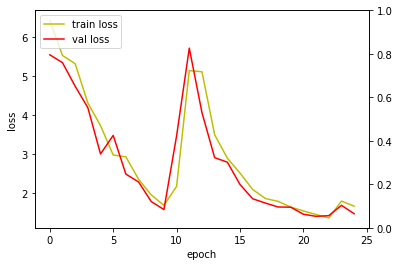

In [44]:
# 5. 학습 과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(googlenet2_history.history['loss'],'y',label='train loss')
loss_ax.plot(googlenet2_history.history['val_loss'],'r',label='val loss')
# acc_ax.plot(googlenet2_history.history['accuracy'],'b',label='train acc')
# acc_ax.plot(googlenet2_history.history['val_accuracy'],'g',label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
#acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
#acc_ax.legend(loc='lower left')
plt.show()

In [43]:
googlenet2_history.history.items()

dict_items([('loss', [6.432361602783203, 5.528187274932861, 5.31685733795166, 4.3100762367248535, 3.725224733352661, 2.9715094566345215, 2.923906087875366, 2.3495261669158936, 1.946966290473938, 1.6778607368469238, 2.1672284603118896, 5.139902114868164, 5.109037399291992, 3.4924685955047607, 2.8900253772735596, 2.5068867206573486, 2.0865304470062256, 1.854440450668335, 1.7807692289352417, 1.6337381601333618, 1.5342758893966675, 1.4432363510131836, 1.3558180332183838, 1.7876461744308472, 1.6577494144439697]), ('dense_18_loss', [3.9165046215057373, 3.4058399200439453, 3.311251401901245, 2.767115592956543, 2.379335403442383, 1.90122652053833, 1.8778088092803955, 1.4849417209625244, 1.1881680488586426, 0.9955706000328064, 1.3666681051254272, 3.4128925800323486, 3.336505174636841, 2.277428150177002, 1.8415348529815674, 1.568322777748108, 1.284948706626892, 1.1430096626281738, 1.100351333618164, 0.9902058243751526, 0.9148803353309631, 0.8536093235015869, 0.798042893409729, 1.1330801248550415

In [46]:
# 6. 모델 평가하기
loss_and_metrics = googlenet.evaluate(X_test,y_test,batch_size=32)
#변수명 : X_train, X_test, y_train, y_test 
print('##### Test Result #####')
print('loss : ',str(loss_and_metrics[0]))
print('Accuracy : ',str(loss_and_metrics[1]))

# 7. 모델 저장하기
from tensorflow.python.keras.models import load_model
googlenet.save('googlenet2_test_220420.h5')


34/34 [==============================] - 7s 171ms/step - loss: 1.4631 - dense_18_loss: 0.9089 - dense_15_loss: 0.9057 - dense_17_loss: 0.9418 - dense_18_accuracy: 0.8374 - dense_15_accuracy: 0.8243 - dense_17_accuracy: 0.8374
##### Test Result #####
loss :  1.4631308317184448
Accuracy :  0.9088764190673828
